<h1>OptimisingFlatland: a demo pipeline for MON generation</h1>

This project require you to have the following installed:
    
    > Avogadro (or similar strucure visualiser)
    > ToBBaCo 3.0
    > OpenBabel
    > MOFid
    > Zeo++

and the following python libraries
    
    > pybel
    > rdkit
    > pandas

<h2>Outline</h2>

This notebook goes through the steps taken to generate a database of MONs using a <i>ToBaCCo</i>. The generation of MONs through ToBaCCo is relatively straightforward: you take a topology template, the metal secondary building blocks (nodes), and the organic linkers (edges); you feed these into tobacco.py; and out comes a .cif that represents the MON built by these substituents. The pipeline we have generated is as follows:
    
1. Generate a selection of SBU .cif files that will lead to 2D MOFs, found in [Chem.Soc.Rev.,2009,38, 1257–1283](https://pubs.rsc.org/en/content/articlepdf/2009/cs/b817735j)

2. Identify common organic backbones found in MONs and mutate them with a variety of functional groups
    
3. Use [ToBaCCo 3.0](https://github.com/tobacco-mofs/tobacco_3.0) to generate all possible MOFs that arise from these nodes and edges

4. Optimise the MON structure using a universal forcefield
    
5. Use [MOFid](https://github.com/snurr-group/mofid) to uniquely identify all of these new structures 

6. Use [Zeo++](http://zeoplusplus.org/) to calculate pore size from the .cif files

<h2>Step 1: generating new SBUs</h2>

Page 1261 in Chem.Soc.Rev.,2009,38, 1257–1283 shows a square paddle-wheel like structure that can be made of 24 different metals. We will choose cobalt here.

Firstly we generate the structure in [Avogadro](https://avogadro.cc/) and use the AutoOpt feature to find the minimum energy structure (shown in figure 1 below)

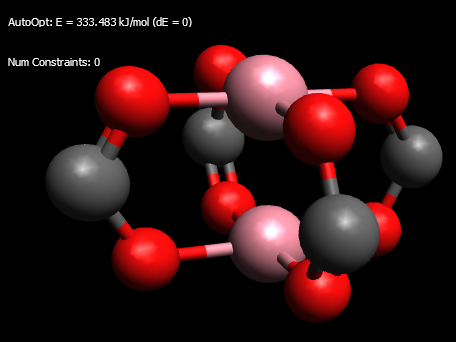

<center><b>Fig. 1</b> A cobalt paddle-wheel SBU.</center>

This structure is then saved as a .cml file.

ToBaCCo works using .cif files of a very particular format, so each .cml must be converted into a .cif file using the following code.

NOTE: ToBaCCo uses an 'X' to denote the atom that connects the SBUs and edges. In almost all cases this atom is a carbon atom of a carboxyl group, and there are no other carbon atoms in the SBU. Thus, for most SBUs we can simply replace any instances of 'C' with 'X' for atom labels. To do this automatically 'replace_C_with_X' must be 'True' in the following code. For SBUs with carbon atoms that do not bond to edges ensure this is set to 'False'.

In [4]:
# Some day I will tidy this up so it isn't so horrible

from openbabel import openbabel
from openbabel import pybel
import os
import pandas as pd
import re
import datetime

path = 'nodes/'

# Initialize the OpenBabel object that we will use later.
obConversion = openbabel.OBConversion()
obConversion.SetInFormat("cml")
ob = pybel.ob

replace_C_with_X = True
get_unit_cell_from_file = False

for f in os.scandir(path):
    # Define containers
    bond_atom_0 = []
    bond_atom_1 = []
    bond_order = []
    bond_length = []
    atom_label = []
    x_coord = []
    y_coord = []
    z_coord = []
    element = []
    
    # Initialize an OBMol object
    mol = ob.OBMol()
    read_ok = obConversion.ReadFile(mol, f.path)
    if not read_ok:
        # There was an error reading the file
        raise Exception(f'Could not read file {f.path}')
    
    mol_name = f.name[:-4]
    num_atoms = mol.NumAtoms()
    
    # Assign unit cell data
    if get_unit_cell_from_file:
        molecule = pybel.Molecule(mol)
        unit_cell = molecule.unitcell
        a = unit_cell.GetA()
        b = unit_cell.GetB()
        c = unit_cell.GetC()
        alpha = unit_cell.GetAlpha()
        beta = unit_cell.GetBeta()
        gamma = unit_cell.GetGamma()
    else:
        a = 20
        b = 20
        c = 20
        alpha = 90
        beta = 90
        gamma = 90
    
    # Extracting atom labels and fractional coordinates
    for i in range(1, num_atoms + 1):
        atom = mol.GetAtom(i)
        # Divide by unit cell parameter to recover fractional coords
        # This is only doable simply because it is a cubic unit cell
        x_coord.append(round(atom.GetX() / a, 6))
        y_coord.append(round(atom.GetY() / b, 6))
        z_coord.append(round(atom.GetZ() / c, 6))
        atom_symb = atom.GetType()
        # Remove numbers and hyphens that openbabel includes in atom type
        atom_symb = ''.join(i for i in atom_symb if not i.isdigit())
        atom_symb = atom_symb.replace('-','')
        element.append(atom_symb)
        # Add correct indexing for connectivity
        if replace_C_with_X:
            if atom_symb=='C':
                atom_id = 'X' + str(i)
            else:
                atom_id = atom_symb + str(i)
        else:
            atom_id = atom_symb + str(i)
        atom_label.append(atom_id)
        
    coordinate_df = pd.DataFrame({'atom_label': atom_label,
                                  'element': element,
                                  'fract_x_coord': x_coord,
                                  'fract_y_coord': y_coord,
                                  'fract_z_coord': z_coord,
                                 })
    
        
    # Extract bonding information
    mol_bonds = openbabel.OBMolBondIter(mol) # iterate over all the bonds in the molecule
    for bond in mol_bonds:
        bond_atom_0.append(bond.GetBeginAtomIdx() - 1) # Must be 0-indexed
        bond_atom_1.append(bond.GetEndAtomIdx() - 1)
        bond_length.append(bond.GetLength())
        bond_order.append(bond.GetBondOrder())
        
    # Put bonding data into a dataframe
    bonding_df = pd.DataFrame({'atom_0': bond_atom_0,
                               'atom_1': bond_atom_1,
                               'length': bond_length,
                               'symmetry': '.',
                               'order': bond_order
                              })
    
    bonding_df = bonding_df.sort_values(['atom_0', 'atom_1']).reset_index(drop=True)    

    # Relabel bonding_df to work with ToBaCCo
    for i in range(0, num_atoms):
        bonding_df['atom_0'] = bonding_df['atom_0'].replace(i, atom_label[i])
        bonding_df['atom_1'] = bonding_df['atom_1'].replace(i, atom_label[i])
        bonding_df['order'] = bonding_df['order'].replace(1, 'S')
        bonding_df['order'] = bonding_df['order'].replace(2, 'D')
        bonding_df['order'] = bonding_df['order'].replace(3, 'T')
    
    # Data checks
    #print(mol_name)
    #print(a,b,c,alpha,beta,gamma)
    print(coordinate_df)
    #print(coordinate_df.to_csv(sep=' ',index=False,header=False))
    #print(bonding_df.to_csv(sep=' ',index=False,header=False))

   atom_label element  fract_x_coord  fract_y_coord  fract_z_coord
0         Co1      Co       0.000000       0.000000       0.111337
1         Co2      Co       0.000000       0.000000       0.000000
2          O3       O      -0.090562      -0.007882       0.112236
3          O4       O      -0.090209      -0.007638       0.001055
4          O5       O       0.090641       0.007896       0.111437
5          O6       O       0.090133       0.007656       0.000249
6          X7       C      -0.122302      -0.010503       0.060143
7          X8       C       0.122296       0.010541       0.059264
8          O9       O      -0.007889       0.090149       0.110665
9         O10       O      -0.007707       0.090614      -0.000521
10        O11       O       0.007889      -0.090146       0.110767
11        O12       O       0.007709      -0.090630      -0.000419
12        X13       C       0.010537      -0.122303       0.051723
13        X14       C      -0.010543       0.122294       0.05

In [12]:
# Write the information to a .cif file in the format needed by ToBaCCo

with open('%s.cif' % mol_name, 'w') as out:
    out.write('data_' + mol_name + '\n')
    out.write('_audit_creation_date              ' + datetime.datetime.today().strftime('%Y-%m-%d') + '\n')
    out.write("_audit_creation_method            'adam'" + '\n')
    out.write("_symmetry_space_group_name_H-M    'P1'" + '\n')
    out.write('_symmetry_Int_Tables_number       1' + '\n')
    out.write('_symmetry_cell_setting            triclinic' + '\n')
    out.write('loop_' + '\n')
    out.write('_symmetry_equiv_pos_as_xyz' + '\n')
    out.write('  x,y,z' + '\n')
    out.write('_cell_length_a                    ' + str(a) + '\n')
    out.write('_cell_length_b                    ' + str(b) + '\n')
    out.write('_cell_length_c                    ' + str(c) + '\n')
    out.write('_cell_angle_alpha                 ' + str(alpha) + '\n')
    out.write('_cell_angle_beta                  ' + str(beta) + '\n')
    out.write('_cell_angle_gamma                 ' + str(gamma) + '\n')
    out.write('loop_' + '\n')
    out.write('_atom_site_label' + '\n')
    out.write('_atom_site_type_symbol' + '\n')
    out.write('_atom_site_fract_x' + '\n')
    out.write('_atom_site_fract_y' + '\n')
    out.write('_atom_site_fract_z' + '\n')
    out.write(coordinate_df.to_csv(sep=' ',index=False,header=False))
    out.write('loop_' + '\n')
    out.write('_geom_bond_atom_site_label_1' + '\n')
    out.write('_geom_bond_atom_site_label_2' + '\n')
    out.write('_geom_bond_distance' + '\n')
    out.write('_geom_bond_site_symmetry_2' + '\n')
    out.write('_ccdc_geom_bond_type' + '\n')
    out.write(bonding_df.to_csv(sep=' ',index=False,header=False))

This gives us a .cif file with the following content

which can now be used in ToBaCCo.

All in alll ~75 metal SBUs were generated this way.

<h2>Mutating common organic backbones</h2>

Next to generate a training set big enough for a neural network (on the scale of 10^6) a number of organic linkers need to be generated. Through the help of people in the Foster group we identified 11 organic linker backbones common in current MOF chemistry that would be suitable for MONs.

These 11 backbones were then mutated with 32 different functional groups (identified by [Yao et. al.](https://chemrxiv.org/articles/preprint/Inverse_Design_of_Nanoporous_Crystalline_Reticular_Materials_with_Deep_Generative_Models/12186681/2)) that are also common in MOF chemistry. Each backbone was mutated with only one type of functional group at a time to avoid creating structures that would be too synthetically unfeasable.

NOTE: Xe is simply a placeholder atom to signify where the bond to the SBU is made.

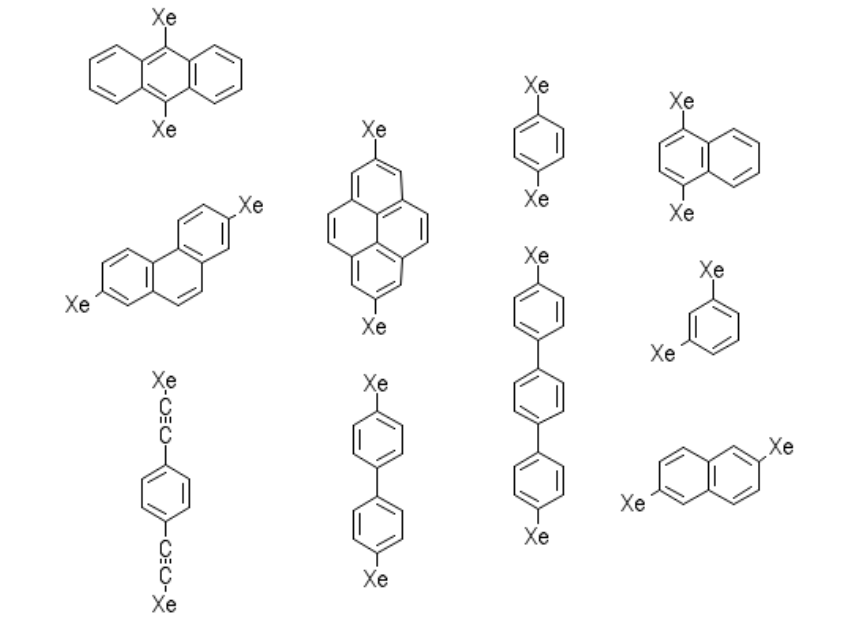

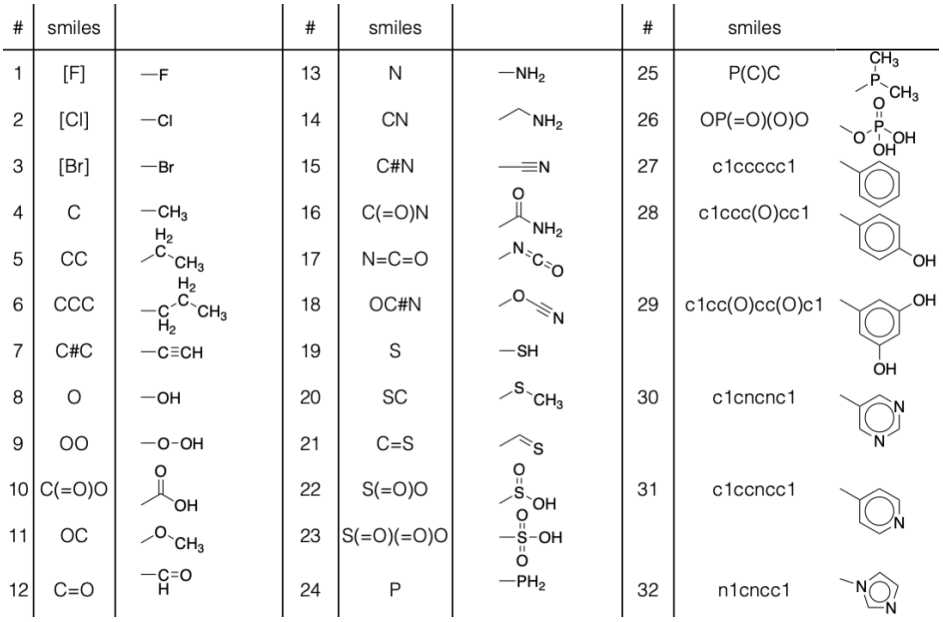

The following code uses <it>rdkit</it> to cycle through each backbone and mutate it with each functional group at every position of a hydrogen, generating a list of SMILES strings containing every permutation of combining the two.

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem

backbones=["C1=CC(=CC=C1C2=CC=C(C=C2)[Xe])[Xe]"]
#backbones=["C=C"]
mutators=["[Rb]C(=O)N"]
mutated_mols = []
rxn = AllChem.ReactionFromSmarts("[Rb][*:1].[Rb][*:2]>>[*:1][*:2]")

for mol in backbones:
    patt = Chem.MolFromSmarts('[H]')
    repl = Chem.MolFromSmarts('[Rb]')
    bb_with_rb = []
    mol_to_mutate = []
    bb_mol=Chem.MolFromSmiles(mol)
    bb_with_h=Chem.AddHs(bb_mol)
    num_h = bb_with_h.GetNumAtoms()- bb_with_h.GetNumHeavyAtoms()
    mol_to_mutate.append(mol)
    for i in range(num_h):
        all_permutations=[]
        for x in mol_to_mutate:
            mol=Chem.MolFromSmiles(x)
            mol_with_h=Chem.AddHs(mol)
            mol_with_rb = Chem.ReplaceSubstructs(mol_with_h,patt,repl)
            for y in mol_with_rb:
                mol_without_h = Chem.RemoveHs(y)
                mutated_smiles = Chem.MolToSmiles(mol_without_h)
                all_permutations.append(mutated_smiles)
        removed_similar = list(set(all_permutations))
        mol_to_mutate = mol_to_mutate + removed_similar
        
    bb_with_rb = list(set(mol_to_mutate))

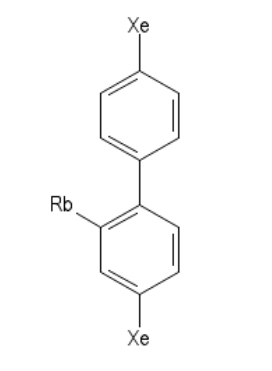

In [11]:
for mut in mutators:
    to_mutate = bb_with_rb
    for i in range(num_h+1):
        for smiles in to_mutate:
            if "[Rb]" not in smiles:
                mutated_mols.append(smiles)
        mutated=[]
        for bb in to_mutate:
            backbone = Chem.MolFromSmiles(bb)
            mutator = Chem.MolFromSmiles(mut)
            results = rxn.RunReactants( [backbone, mutator] )
            for products in results:
                for mol in products:
                    mutated.append(Chem.MolToSmiles(mol))
        to_mutate = list(set(mutated))
        
#print(mutated_mols)
print(len(mutated_mols))

55


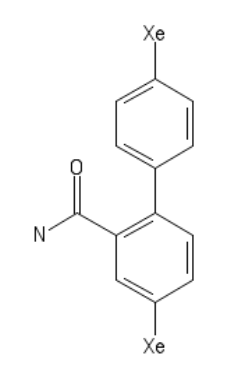

Each of these smiles strings is then converted to a .cml file, with bonding information, using [OpenBabel](http://openbabel.org/wiki/Main_Page).

    $ obabel infile -O outfile.cml --gen3d

This can then be fed into similar code we used to generate .cifs for SBUs to generate a set of cifs suitable for ToBaCCo. This code differs in that it does not automatically convert the labels on carbons to 'Xs', instead it checks to see if the carbon is bonded to Xe, changes its label if it is, and then removes the Xe from the molecule.

(IN HINDSIGHT THIS COULD ALSO BE USED FOR SBU GENERATION, BUT I WOULD HAVE TO ADD Xe TO EVERY SBU IN AVOGADRO AND I DON'T KNOW IF I WANT TO)

In [115]:
from openbabel import openbabel
from openbabel import pybel
import os
import pandas as pd
import re
import datetime

path = 'edges/'

obConversion = openbabel.OBConversion()
obConversion.SetInFormat("cml")
ob = pybel.ob

replace_C_with_X = False

for f in os.scandir(path):
    bond_atom_0 = []
    bond_atom_1 = []
    bond_order = []
    bond_length = []
    atom_label = []
    x_coord = []
    y_coord = []
    z_coord = []
    element = []
    
    mol = ob.OBMol()
    read_ok = obConversion.ReadFile(mol, f.path)
    if not read_ok:
        raise Exception(f'Could not read file {f.path}')
    
    mol_name = f.name[:-4]
    num_atoms = mol.NumAtoms()
    
    a = 20
    b = 20
    c = 20
    alpha = 90
    beta = 90
    gamma = 90
    
    for i in range(1, num_atoms + 1):
        atom = mol.GetAtom(i)
        x_coord.append(round(atom.GetX() / a, 6))
        y_coord.append(round(atom.GetY() / b, 6))
        z_coord.append(round(atom.GetZ() / c, 6))
        atom_symb = atom.GetType()
        atom_symb = ''.join(i for i in atom_symb if not i.isdigit())
        atom_symb = atom_symb.replace('-','')
        if atom_symb=='Car':
            element.append('C')
            atom_id = 'C' + str(i)
        else:
            element.append(atom_symb)
            atom_id = atom_symb + str(i)
        atom_label.append(atom_id)
        
    coordinate_df = pd.DataFrame({'atom_label': atom_label,
                                  'element': element,
                                  'fract_x_coord': x_coord,
                                  'fract_y_coord': y_coord,
                                  'fract_z_coord': z_coord,
                                 })
    
        
    mol_bonds = openbabel.OBMolBondIter(mol)
    for bond in mol_bonds:
        bond_atom_0.append(bond.GetBeginAtomIdx() - 1)
        bond_atom_1.append(bond.GetEndAtomIdx() - 1)
        bond_length.append(bond.GetLength())
        bond_order.append(bond.GetBondOrder())
        
    bonding_df = pd.DataFrame({'atom_0': bond_atom_0,
                               'atom_1': bond_atom_1,
                               'length': bond_length,
                               'symmetry': '.',
                               'order': bond_order
                              })
    
    bonding_df = bonding_df.sort_values(['atom_0', 'atom_1']).reset_index(drop=True)    

    for i in range(0, num_atoms):
        bonding_df['atom_0'] = bonding_df['atom_0'].replace(i, atom_label[i])
        bonding_df['atom_1'] = bonding_df['atom_1'].replace(i, atom_label[i])
        bonding_df['order'] = bonding_df['order'].replace(1, 'S')
        bonding_df['order'] = bonding_df['order'].replace(2, 'D')
        bonding_df['order'] = bonding_df['order'].replace(3, 'T')
    
###### DIFFERENT TO SBU CODE FROM HERE ######
    
    # Checks to see if carbon is bonded to Xe, if true change to X
    num_bonds = len(bonding_df)
    y=[]
    z=[]
    for i in range(num_bonds):
        for j in range(2):
            if re.search(r"Xe\d", bonding_df.iloc[i]['atom_' + str(j)]):
                x = bonding_df.iloc[i]['atom_' + str(1-j)]
                y.append(x)
                z.append(x.replace('C','X'))

    for j in range(len(y)):
        for i in range(num_atoms):
            if re.search(y[j], coordinate_df.iloc[i]['atom_label']):
                coordinate_df.at[i, 'atom_label'] = z[j]
        for i in range(num_bonds):
            for k in range(2):
                if re.search(y[j], bonding_df.iloc[i]['atom_' + str(k)]):
                    bonding_df.at[i, 'atom_' + str(k)] = z[j]
    
    # Drop rows with Xe anywhere in them
    relabeled_coordinate_df = coordinate_df[~coordinate_df.element.str.contains('Xe')]
    temp_bonding_df = bonding_df[~bonding_df.atom_0.str.contains(r"Xe\d")]
    relabeled_bonding_df = temp_bonding_df[~temp_bonding_df.atom_1.str.contains(r"Xe\d")]
    

In [114]:
with open('%s.cif' % mol_name, 'w') as out:
    out.write('data_' + mol_name + '\n')
    out.write('_audit_creation_date              ' + datetime.datetime.today().strftime('%Y-%m-%d') + '\n')
    out.write("_audit_creation_method            'adam'" + '\n')
    out.write("_symmetry_space_group_name_H-M    'P1'" + '\n')
    out.write('_symmetry_Int_Tables_number       1' + '\n')
    out.write('_symmetry_cell_setting            triclinic' + '\n')
    out.write('loop_' + '\n')
    out.write('_symmetry_equiv_pos_as_xyz' + '\n')
    out.write('  x,y,z' + '\n')
    out.write('_cell_length_a                    ' + str(a) + '\n')
    out.write('_cell_length_b                    ' + str(b) + '\n')
    out.write('_cell_length_c                    ' + str(c) + '\n')
    out.write('_cell_angle_alpha                 ' + str(alpha) + '\n')
    out.write('_cell_angle_beta                  ' + str(beta) + '\n')
    out.write('_cell_angle_gamma                 ' + str(gamma) + '\n')
    out.write('loop_' + '\n')
    out.write('_atom_site_label' + '\n')
    out.write('_atom_site_type_symbol' + '\n')
    out.write('_atom_site_fract_x' + '\n')
    out.write('_atom_site_fract_y' + '\n')
    out.write('_atom_site_fract_z' + '\n')
    out.write(relabeled_coordinate_df.to_csv(sep=' ',index=False,header=False))
    out.write('loop_' + '\n')
    out.write('_geom_bond_atom_site_label_1' + '\n')
    out.write('_geom_bond_atom_site_label_2' + '\n')
    out.write('_geom_bond_distance' + '\n')
    out.write('_geom_bond_site_symmetry_2' + '\n')
    out.write('_ccdc_geom_bond_type' + '\n')
    out.write(relabeled_bonding_df.to_csv(sep=' ',index=False,header=False))

<h2>Running ToBaCCo</h2>
    
Once all of these .cif files are generated, running ToBaCCo is very easy. Place the SBU .cifs in the 'nodes' folder, place the mutated linkers in the 'edges' folder, place the 2D-topography .cifs in the 'templates' folder and run:
    
    $ python3 tobacco.py
    
This outputs to 'output_cifs' which can then be cycled through at our lesiure

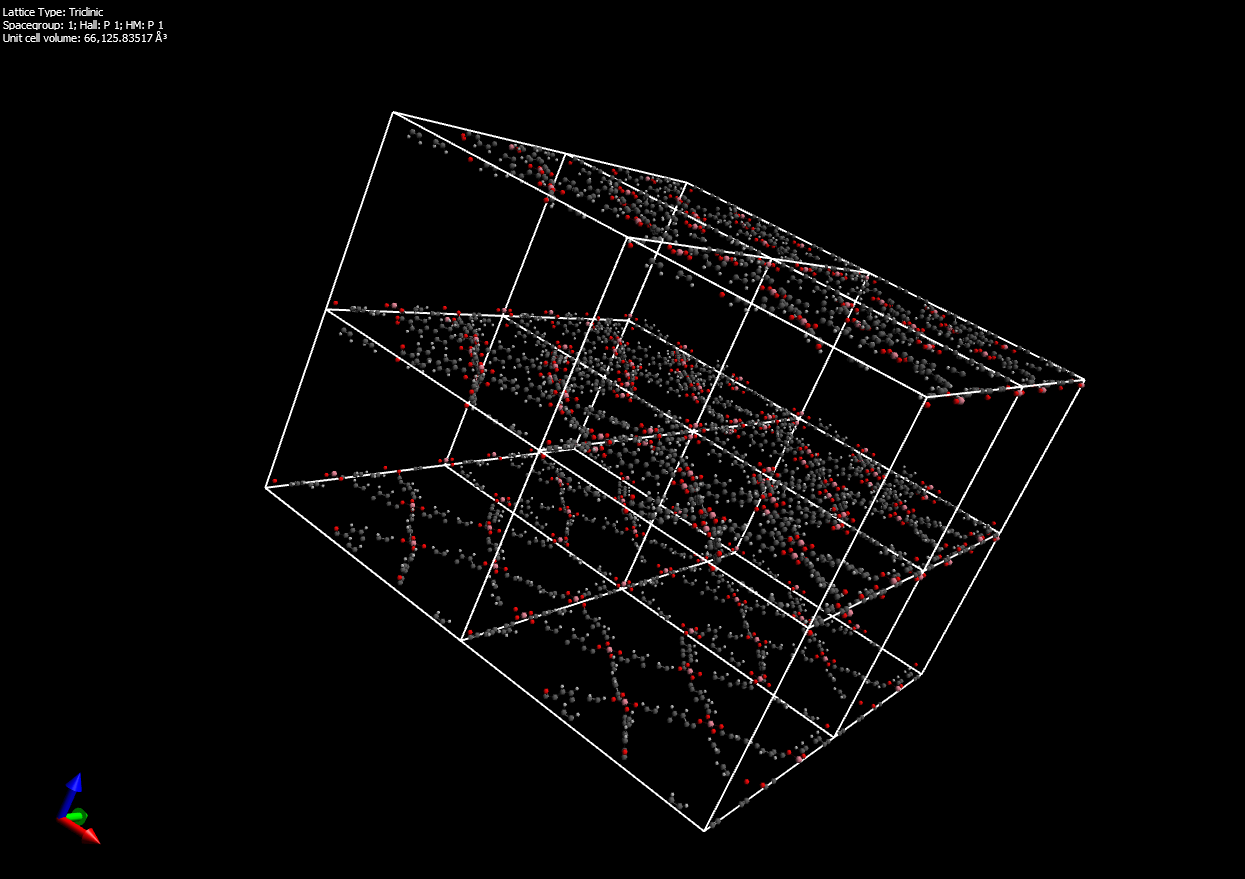

<center><b>Fig. 1</b> The MON generated by running ToBaCCo with the pna.cif template, with the Cobalt paddlewheel from before, and the organic linker shown in the mutation example.</center>

<h2>Optimising structure</h2>

We can very quickly and easily optimised our outputs from ToBaCCo using OpenBabel's [OBminimize](https://openbabel.org/wiki/Obminimize). Thus, every .cif is passed through this program before we calculate any values on the new MONs.

    $ for f in * ; do obminimize -ff uff $f ; done
    
Using '-sd' will specify to use the steepest descent algorithm as opposed to the conjugate gradients algorithm (default), and using '-c' we can specify the convergence criteria.

<h2>MOFid</h2>

It is important that these new MONs can be identified and also fed into a neural network. This kind of unique identifying string can be easily generated by running each .cif through [MOFid](https://github.com/snurr-group/mofid) a program written to do just that.

In [4]:
from mofid.run_mofid import cif2mofid
cif_path = 'pna_v1-4c_Co_pw_v2-4c_Co_pw_v3-4c_Co_pw_2b_linear.cif'
mofid = cif2mofid(cif_path)

MOFid: 

    [Co][Co].[O-]C(=O)c1ccc(cc1)c1ccc(cc1)C(=O)[O-] MOFid-v1.pna.cat0;pna_v1-4c_Co_pw_v2-4c_Co_pw_v3-4c_Co_pw_2b_linear
    
MOFkey:

    Co.NEQFBGHQPUXOFH.MOFkey-v1.pna

<h2>Property calculation</h2>

Easily done through Zeo++

    $ ./network -ha -res pna_v1-4c_Co_pw_v2-4c_Co_pw_v3-4c_Co_pw_2b_linear.cif
    
Results (1) the largest included sphere, (2) the largest free sphere, and (3) the largest included sphere along the free sphere path.

       pna...linear.res    31.51260 27.96832  31.40648

<h2>Database</h2>

Using HDF5 we can store the cif files with their corresponding MOFids and any properties we calculate for that .cif

In [4]:
import h5py
import numpy as np

file = h5py.File ('file.h5', 'w')
dataset = file.create_dataset("dset",(4, 6), h5py.h5t.STD_I32BE)
data = np.zeros((4,6))
for i in range(4):
    for j in range(6):
        data[i][j]= i*6+j+1
dataset[...] = data
data_read = dataset[...]

group = file.create_group ('MyGroup')

print(data_read)

file.close ()

[[ 1  2  3  4  5  6]
 [ 7  8  9 10 11 12]
 [13 14 15 16 17 18]
 [19 20 21 22 23 24]]
